# Ligand-Based Virtual Drug Screening Experiment

### Introduction

Ligand-based virtual drug screening is a computational approach that predicts the activity of candidate molecules against a specific biological target by learning patterns from known active and inactive ligands, without requiring the target’s structural information.

A ligand is a small molecule that binds to a biological target (usually a protein).

For example, Alzheimer's disease's proteins are:
- Amyloid Beta (Aβ)
- Tau Protein.

### Methodology

Given a high quality dataset of known active and inactive ligands, we can:
1. Retrieve their SMILES string representation from the ChEMBL database.
2. Fingerprint the molecules by converting the SMILES strings into numerical feature vectors using RDKit’s Morgan fingerprinting (ECFP6) and the Extended fingerprint.

We use both ECFP6 and the Extended fingerprint because ECFP6 captures the presence of small, local substructures, while the Extended fingerprint captures how those substructures are connected across the molecule over longer distances.

Combining them provides a more holistic representation of each molecule, allowing the model to identify richer patterns associated with active ligands.

We concatenate ECFP6 and the Extended fingerprint so the model can simultaneously learn from local substructures and global molecular connectivity, giving it a more complete description of each molecule without losing information.

### Training the Machine Learning (ML) Model


A Support Vector Machine (SVM) is an machine learning (ML) model that tries to draw the best possible boundary between two classes (active / inactive) so that they are seperated as cleanly as possible.

- On one side of the boundary → fingerprint patterns look active-like
- On the other side → fingerprint patterns look inactive-like

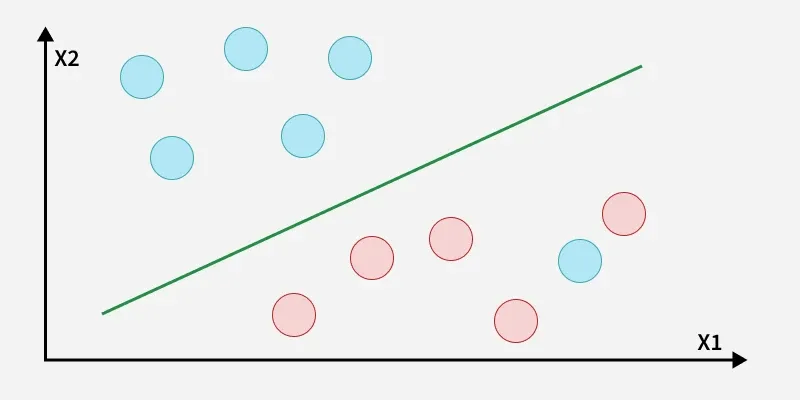

### Evaluating Results

By learning a decision boundary with a sufficiently large margin in fingerprint space, the SVM is able to generalise to unseen molecules, allowing it to predict whether a ligand is active or inactive with respect to a specific biological target, typically a protein.

We reproduced the reported performance of an SVM classifier with standalone ECFP6 fingerprints, achieving approximately 98% accuracy on a held-out, balanced test set, with precision, recall, and F1-score all around 0.98

This supports the claim that high-quality data combined with conventional machine-learning methods enables near-perfect ligand-based virtual screening.



### Table of Contents
1. Data Preparation
2. Fingerprint Generation
   - Defining functions for fingerprint generation
   - Defining a method for fingerprint merging
   - Building fingerprints and converting activity labels
3. Training the Support Vector Machine (SVM)
4. Testing the Model
   - Building test fingerprints
   - Testing the SVM model
5. Evaluating Results
6. Conclusion
7. References


### 1. Data Preparation

The data contains ChEMBL representations of molecular structures and their corresponding activity labels (active/inactive) with respect to a specific biological target protein used for virtual screening.

In [22]:
import pandas as pd

xls = pd.ExcelFile('587184_file06.xlsx')

In [23]:
xls.sheet_names

['Main training set 1',
 'Main training set 2',
 'Main training set 3',
 'Main training set 4',
 'Main training set 5',
 'Main test set']

In [24]:
df = pd.read_excel(xls, 'Main training set 3')
df

,chembl_id,label
0,CHEMBL3335385,posi
1,CHEMBL3234741,posi
2,CHEMBL3661260,posi
3,CHEMBL4289810,posi
4,CHEMBL3960515,posi
...,...,...
7195,CHEMBL147604,nega
7196,CHEMBL2135638,nega
7197,CHEMBL3962968,nega
7198,CHEMBL2178943,nega


In [26]:
from chembl_webresource_client.new_client import new_client

molecule = new_client.molecule

ids = df["chembl_id"].tolist()   # ← keep full list, no dropping rows
unique_ids = list(set(ids))      # ← internal lookup only

records = molecule.filter(
    molecule_chembl_id__in=unique_ids
).only(
    "molecule_chembl_id",
    "molecule_structures"
)

id_to_smiles = {
    r["molecule_chembl_id"]:
        (r.get("molecule_structures") or {}).get("canonical_smiles")
    for r in records
}
df["smiles"] = df["chembl_id"].map(id_to_smiles)

In [27]:
missing = df["smiles"].isna().sum()
print("Missing SMILES:", missing)

df[df["smiles"].isna()].head()


Missing SMILES: 0


,chembl_id,label,smiles


In [28]:
df

,chembl_id,label,smiles
0,CHEMBL3335385,posi,CC(C)N1CCC(C(=O)Nc2cc(Oc3ccc4c(c3)nc(Nc3cc(C(F...
1,CHEMBL3234741,posi,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...
2,CHEMBL3661260,posi,COc1cc(-c2ccc3ncnc(Nc4cccc5[nH]ncc45)c3c2)ccc1F
3,CHEMBL4289810,posi,Cc1ccc(C(=O)Nc2ccc(C(F)(F)F)c(Cl)c2)cc1NC(=O)C...
4,CHEMBL3960515,posi,Cc1ncc(NC(=O)c2cccc(C(F)F)c2)cc1-c1ccnc(N2CCOC...
...,...,...,...
7195,CHEMBL147604,nega,O=C(NO)C1c2ccc(OCc3ccccc3)cc2CCN1S(=O)(=O)c1cc...
7196,CHEMBL2135638,nega,O=C(NCc1ccccc1)[C@@H]1CCCN1C(=O)[C@@H]1CCCN1C(...
7197,CHEMBL3962968,nega,CN1CC2(CCN(c3cncc([C@](C)(O)C(F)(F)F)c3)CC2)CC1=O
7198,CHEMBL2178943,nega,Cc1nc(C)c(-c2ccc([C@H]3CC[C@H](CC(=O)O)CC3)c(C...


### 2.1 Defining Functions for Fingerprint Generation

Extended-Connectivity Fingerprint Diameter 6 (ECFP6)

In [29]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem

# define function that transforms SMILES strings into ECFP6 fingerprints
def ECFP6_from_smiles(smiles,
                     R = 3,
                     L = 2**10,
                     use_features = False,
                     use_chirality = False):
    
    molecule = AllChem.MolFromSmiles(smiles)
    feature_list = AllChem.GetMorganFingerprintAsBitVect(
        molecule,
        radius = R,
        nBits = L,
        useFeatures = use_features,
        useChirality = use_chirality
    )

    return np.array(feature_list).tolist()

Extended Fingerprint

In [31]:
from rdkit.Chem import RDKFingerprint

def extended_fp(smiles):
    molecule = Chem.MolFromSmiles(smiles)
    return RDKFingerprint(molecule)

### 2.2 Defining Methods for Fingerprint Merging

Merging fingerprints

In [32]:
def merge_fingerprints(fp1, fp2):
    """
    Inputs:
    
    - fp1 ... first fingerprint as a list
    - fp2 ... second fingerprint as a list
    
    Outputs:
    - merged_fp ... merged fingerprint as a list
    """
    merged_fp = np.concatenate((np.array(fp1), np.array(fp2)))
    return merged_fp.tolist()

### 2.3 Building Fingerprints and Performing Binary Conversion on Activity Labels

In [33]:
X_train = np.array([
    ECFP6_from_smiles(smiles) for smiles in df['smiles']
])

y_train = df["label"].map({
    "posi": 1,
    "nega": 0
}).values

print(np.unique(y_train))
print(np.bincount(y_train))

[0 1]
[3600 3600]


### 3. Training the Support Vector Machine (SVM) model

In [34]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10],
    "kernel": ["rbf"],
    "gamma": ["scale"]
}

svm = GridSearchCV(
    SVC(),
    param_grid,
    scoring = 'accuracy',
    cv = 10
)

svm.fit(X_train, y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",SVC()
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'C': [0.1, 1, ...], 'gamma': ['scale'], 'kernel': ['rbf']}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",10
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is also displayed;- >3 : the fold and c

In [35]:
print(svm.best_params_)
print(svm.best_score_)


{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.9879166666666667


### 4.1 Testing the SVM Model


Load the test set

In [36]:
df_test = pd.read_excel(xls, "Main test set")
df_test.head()

,chembl_id,label
0,CHEMBL4519687,nega
1,CHEMBL1342440,nega
2,CHEMBL4745638,nega
3,CHEMBL443102,nega
4,CHEMBL2018813,nega


Add SMILES conversion

In [37]:
missing_ids = df_test.loc[
    ~df_test["chembl_id"].isin(id_to_smiles),
    "chembl_id"
].unique().tolist()

if missing_ids:
    records = molecule.filter(
        molecule_chembl_id__in=missing_ids
    ).only(
        "molecule_chembl_id",
        "molecule_structures"
    )

    for r in records:
        mid = r["molecule_chembl_id"]
        smi = (r.get("molecule_structures") or {}).get("canonical_smiles")
        id_to_smiles[mid] = smi
        
df_test["smiles"] = df_test["chembl_id"].map(id_to_smiles)

In [38]:
print("Missing SMILES in test:", df_test["smiles"].isna().sum())
print(df_test["label"].value_counts())


Missing SMILES in test: 0
label
posi    501
nega    500
Name: count, dtype: int64


### 4.2 Building Test Fingerprints

In [39]:
X_test = np.array([
    ECFP6_from_smiles(s) for s in df_test["smiles"]
])

y_test = df_test["label"].map({
    "posi": 1,
    "nega": 0
}).values


### 5. Evaluating Results

In [40]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = svm.best_estimator_.predict(X_test)

print("Test accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Test accuracy: 0.98001998001998
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       500
           1       0.98      0.98      0.98       501

    accuracy                           0.98      1001
   macro avg       0.98      0.98      0.98      1001
weighted avg       0.98      0.98      0.98      1001



### 6. Conclusion

Using the authors’ curated BRAF dataset, we reproduced the reported performance of an SVM classifier with standalone ECFP6 fingerprints, achieving approximately 98% accuracy on a held-out, balanced test set, with precision, recall, and F1-score all around 0.98.

This is consistent with the results reported by Chong et al. and supporting the claim that high-quality data combined with conventional machine-learning methods enables near-perfect ligand-based virtual screening.

### 7. References
- https://elifesciences.org/reviewed-preprints/97821
- https://www.blopig.com/blog/2022/11/how-to-turn-a-smiles-string-into-an-extended-connectivity-fingerprint-using-rdkit/